**Ubacivanje biblioteka**

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from tensorflow.keras import optimizers
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization
)
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

**Preprocesiranje podataka**

In [ ]:
################# Define pil image method
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    imshow(np.asarray(pil_im))
    return pil_im


################# define noise image method
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

################# Define blur image method
def blur_image(pil_im):
    #Adding Blur to image
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # output
    imshow(blur_img)
    blur_img = blur_img.resize((105, 105))
    return blur_img

################# define affine rotation method
def affine_rotation(img):
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img
   
################# define gradient fill method
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train i test skup podataka

Success


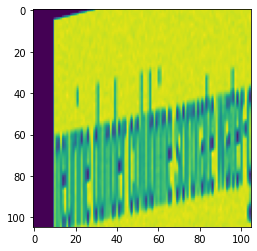

In [ ]:
################# get path
data_path = "/content/drive/MyDrive/data_500"



data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)
##print(imagePaths);

################# Define labels for model
def conv_label(label):
    if label == 'Pacifico':
        return 0
    elif label == 'DroidSans':
        return 1
    elif label == 'Roboto-Regular':
        return 2


################# Define methods
augument=["blur","noise","affine","gradient"]
a=itertools.combinations(augument, 4)

##for i in list(a): 
##    print(list(i))


################# Handling font_patch images with previously defined methods
counter=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
  ## imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    augument=["noise","blur","affine","gradient"]
    for l in range(0,len(augument)):
    
        a=itertools.combinations(augument, l+1)

        for i in list(a): 
            combinations=list(i)
          ##  print(len(combinations))
            temp_img = pil_img
            for j in combinations:
            
                if j == 'noise':
                    # Adding Noise image
                    temp_img = noise_image(temp_img)
                    
                elif j == 'blur':
                    # Adding Blur image
                    temp_img = blur_image(temp_img)
                    #imshow(blur_img)
                    
    
                elif j == 'affine':
                    open_cv_affine = np.array(pil_img)
                    # Adding affine rotation image
                    temp_img = affine_rotation(open_cv_affine)

                elif j == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    # Adding gradient image
                    temp_img = gradient_fill(open_cv_gradient)
  
            temp_img = img_to_array(temp_img)
            data.append(temp_img)
            labels.append(label)


################# Preparing data for model creation
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.25, random_state=42)


##nsamples, nx, ny, nz = trainX.shape
##d2_trainX = trainX.reshape((nsamples, nx*ny*nz))

##nsamples, nx, ny, nz = testX.shape
##d2_testX = testX.reshape((nsamples, nx*ny*nz))

################# 
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

################# augtment
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [ ]:
def create_model():
    model=Sequential()

    # Cu Layers 
    model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
    model.add(UpSampling2D(size=(2, 2)))

    #Cs Layers
    model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

    model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

    model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

    model.add(Flatten())

    model.add(Dense(4096, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(4096,activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(2383,activation='relu'))

    model.add(Dense(3, activation='softmax'))
  
    return model


################# defining batch size and number of epochs
batch_size = 128
epochs = 25
model= create_model()

sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
##sgd = optimizers.SGD(learning_rate=lr, decay=decay_rate, momentum=mom, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])


################# defining saving path
early_stopping=callbacks.EarlyStopping(monitor='val_loss', 
                                       min_delta=0, 
                                       patience=10, 
                                       verbose=0, 
                                       mode='min')




#if os.path.exists('/content/drive/MyDrive/MPVI_projekat_model.h5'):
#  os.remove('/content/drive/MyDrive/MPVI_projekat_model.h5')

#model.save('/content/drive/MyDrive/MPVI_projekat_model.h5')

filepath="/content/drive/MyDrive/MPVI_projekat_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]


################# fitting model into filepath
model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

Epoch 1/25
141/141 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.7768
Epoch 1: val_loss improved from inf to 0.33137, saving model to /content/drive/MyDrive/MPVI_projekat_model.h5
141/141 [==============================] - 153s 849ms/step - loss: 0.0928 - accuracy: 0.7768 - val_loss: 0.3314 - val_accuracy: 0.3375
Epoch 2/25
141/141 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9928
Epoch 2: val_loss improved from 0.33137 to 0.21154, saving model to /content/drive/MyDrive/MPVI_projekat_model.h5
141/141 [==============================] - 127s 904ms/step - loss: 0.0043 - accuracy: 0.9928 - val_loss: 0.2115 - val_accuracy: 0.6288
Epoch 3/25
141/141 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9938
Epoch 3: val_loss improved from 0.21154 to 0.04896, saving model to /content/drive/MyDrive/MPVI_projekat_model.h5
141/141 [==============================] - 111s 789ms/step - loss: 0.0039 - accuracy: 0.9938 - val_loss:

In [ ]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 8.263374184025452e-06
Test accuracy: 1.0


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/MPVI_projekat_model.h5')

Primjer za DroidSans

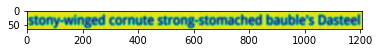

In [ ]:
img_path="/content/drive/MyDrive/stony.jpg"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im=blur_image(pil_im)
org_img = img_to_array(pil_im)

In [ ]:
def rev_conv_label(label):
    if label == 0 :
        return 'Pacifico'
    elif label == 1:
        return 'DroidSans'
    elif label == 2 :
        return 'Roboto-Regular'

In [ ]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [ ]:
y = np.argmax(model.predict(data), axis=-1)

1/1 [==============================] - 0s 23ms/step


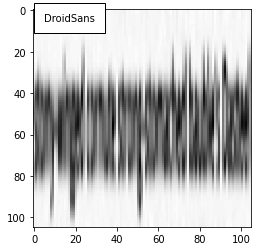

In [ ]:
label = rev_conv_label(int(y[0]))
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()

Primjer za Roboto Regular

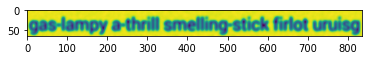

In [ ]:
img_path="/content/drive/MyDrive/gas.jpg"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im=blur_image(pil_im)
org_img = img_to_array(pil_im)

In [ ]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [ ]:
y = np.argmax(model.predict(data), axis=-1)

1/1 [==============================] - 0s 19ms/step


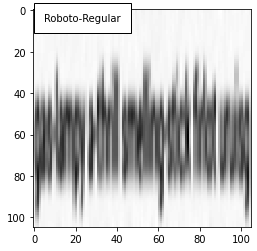

In [ ]:
label = rev_conv_label(int(y[0]))
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()

Primjer za Pacifico

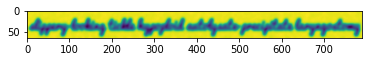

In [ ]:
img_path="/content/drive/MyDrive/slippery.jpg"
pil_im =PIL.Image.open(img_path).convert('L')
pil_im=blur_image(pil_im)
org_img = img_to_array(pil_im)

In [ ]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [ ]:
y = np.argmax(model.predict(data), axis=-1)

1/1 [==============================] - 0s 20ms/step


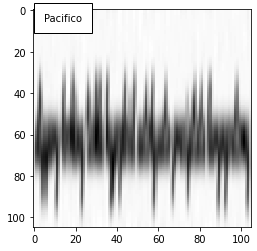

In [ ]:
label = rev_conv_label(int(y[0]))
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()